# Machine Learning Phases of the Ising Model

In this notebook, we will use a PyTorch model to perform training to classify the phases of anti-ferromagnetic square Ising lattices. We then demonstrate that such a model can be used to predict the phases of equivalent triangular lattices.

In [2]:
import torch
import numpy as np
import matplotlib as mpl 
import matplotlib.pylab as plt

In [ ]:
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15 
plt.rcParams['ytick.labelsize'] = 15 
plt.rcParams['axes.labelsize'] = 20 
plt.rcParams['axes.titlesize'] = 19 
plt.rc('font', **{'family': 'serif', 'serif':['Computer Modern']})
plt.rc('text', usetex=True)

First we load the generated lattices and their corresponding temperatures. We assign labels to each lattice based off whether its temperature is below or above the critical temperature in the thermodynamic limit. For the square lattice, the critical temperature is given by: $$T_{c} = \frac{2}{\text{ln}(1 + \sqrt{2})}$$

For the triangular lattices, the critical temperature is: $$T_{c} = \frac{4}{\text{ln}(3)}$$


In [4]:
# Critical temperatures of square and triangular lattices in thermodynamic limit
Tc_train = 2 / np.log(1 + np.sqrt(2))
Tc_test = 4 / np.log(3)

# Load training sets - Square lattices for different sizes, L
lattices_train = [
    torch.load('data/square/L10/lattices.pt', weights_only=False),
    torch.load('data/square/L20/lattices.pt', weights_only=False),
    torch.load('data/square/L30/lattices.pt', weights_only=False),
    torch.load('data/square/L40/lattices.pt', weights_only=False),
    torch.load('data/square/L60/lattices.pt', weights_only=False),
]

temperatures_train = torch.stack([
    torch.load('data/square/L10/temperatures.pt', weights_only=False),
    torch.load('data/square/L20/temperatures.pt', weights_only=False),
    torch.load('data/square/L30/temperatures.pt', weights_only=False),
    torch.load('data/square/L40/temperatures.pt', weights_only=False),
    torch.load('data/square/L60/temperatures.pt', weights_only=False)
])

labels_train = torch.stack([
    (temps < Tc_train).int() for temps in temperatures_train
])

# Load test sets - Triangular lattices for different sizes, L
lattices_test = [
    torch.load('data/triangular/L10/lattices.pt', weights_only=False),
    torch.load('data/triangular/L20/lattices.pt', weights_only=False),
    torch.load('data/triangular/L30/lattices.pt', weights_only=False),
    torch.load('data/triangular/L40/lattices.pt', weights_only=False),
    torch.load('data/triangular/L60/lattices.pt', weights_only=False)
]

temperatures_test = torch.stack([
    torch.load('data/triangular/L10/temperatures.pt', weights_only=False),
    torch.load('data/triangular/L20/temperatures.pt', weights_only=False),
    torch.load('data/triangular/L30/temperatures.pt', weights_only=False),
    torch.load('data/triangular/L40/temperatures.pt', weights_only=False),
    torch.load('data/triangular/L60/temperatures.pt', weights_only=False)
])

labels_test = torch.stack([
    (temps < Tc_test).int() for temps in temperatures_test
])


Let us load and display a $60 \times 60$ square and triangular lattices at high temperatures and low temperatures.

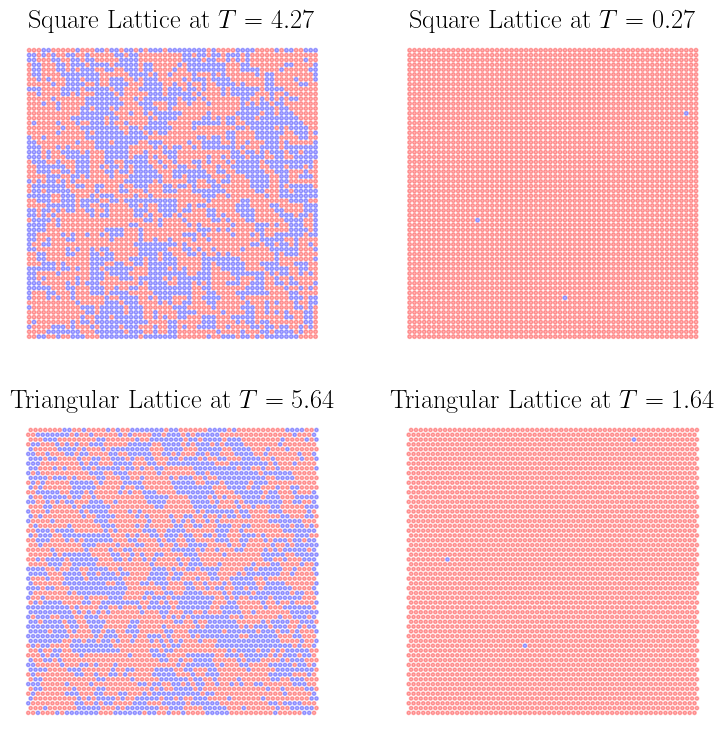

In [5]:
square_temperatures = temperatures_train[-1]
triang_temperatures = temperatures_test[-1]
square_lattices = labels_train[-1]
triang_lattices = lattices_test[-1]

# Plot example square and triangular lattices and low and high temperatures
min_train = torch.argmin(square_temperatures, dim=0)
max_train = torch.argmax(square_temperatures, dim=0)
min_test = torch.argmin(triang_temperatures, dim=0)
max_test = torch.argmax(triang_temperatures, dim=0)

square_lattice_low = square_lattices[min_train]
square_lattice_high = square_lattices[max_train]
triang_lattice_low = triang_lattices[min_test]
triang_lattice_high = triang_lattices[max_test]

colors_train_low, colors_train_high = [], []
colors_test_low, colors_test_high = [], []
x_train, y_train = [], []
x_test, y_test = [], []

for i in range(len(triang_lattice_low)):
    for j in range(len(triang_lattice_low[0])):
        x_train.append(i)
        y_train.append(j)
        colors_train_low.append('red' if triang_lattice_low[i, j] == 1 else 'blue')
        colors_train_high.append('red' if triang_lattice_high[i, j] == 1 else 'blue')

        x_test.append(j + 0.5 * (i % 2))
        y_test.append(np.sqrt(3) / 1.75 * i)
        colors_test_low.append('red' if triang_lattice_low[i, j] == 1 else 'blue')
        colors_test_high.append('red' if triang_lattice_high[i, j] == 1 else 'blue')

fig, axes = plt.subplots(2, 2, figsize=(9, 9))
ax1, ax2, ax3, ax4 = axes.flatten()
ax1.set_title(f'Square Lattice at $T = {square_temperatures[max_train]:.2f}$')
ax1.scatter(x_train, y_train, c=colors_train_high, marker='o', s=7, alpha=.3,)
ax1.set_aspect('equal')

ax2.set_title(f'Square Lattice at $T = {square_temperatures[min_train]:.2f}$')
ax2.scatter(x_train, y_train, c=colors_train_low, marker='o', s=7, alpha=.3,)
ax2.set_aspect('equal')

ax3.set_title(f'Triangular Lattice at $T = {triang_temperatures[max_test]:.2f}$')
ax3.scatter(x_test, y_test, c=colors_test_high, marker='o', s=6, alpha=.3,)
ax3.set_aspect('equal')

ax4.set_title(f'Triangular Lattice at $T = {triang_temperatures[min_test]:.2f}$')
ax4.scatter(x_test, y_test, c=colors_test_low, marker='o', s=6, alpha=.3,)
ax4.set_aspect('equal')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
plt.show()

Here, we define the CNN described in Ref. [1]. The CNN consists of a single convolutional layer, and a fully connected hidden layer.

<div align="center">
  <img src="figures/CNN_diagram.png" alt="Description" width="910" height="500" />
</div>

In [6]:
class CNN(torch.nn.Module):
    def __init__(self, L):
        super().__init__() 
        dims_conv = (L - 2) // 1 + 1

        self._conv = torch.nn.Conv2d(kernel_size=2, stride=1, in_channels=1, out_channels=1)
        self._relu = torch.nn.ReLU()
        self._flatten = torch.nn.Flatten()
        self._linear1 = torch.nn.Linear(in_features=dims_conv ** 2, out_features=64)
        self._dropout = torch.nn.Dropout(p=0.5)
        self._linear2 = torch.nn.Linear(in_features=64, out_features=2)
        self._softmax = torch.nn.Softmax(2)

        self._network = torch.nn.Sequential(
            self._conv,
            self._relu,
            self._flatten,
            self._linear1,
            self._relu,
            self._dropout,
            self._linear2,
        )
    def forward(self, x):
        x = x.unsqueeze(1)
        return self._network(x)

# Create model for each L
lengths_list = [10, 20, 30, 40, 60]
models = [CNN(L) for L in lengths_list]

We now iterate over all the models and perform training.

In [7]:
lr = 1e-5
epochs = 150
batch_size = 5
loss_fn = torch.nn.CrossEntropyLoss()

model_losses = []
model_accuracies_train, model_accuracies_test = [], []

for i, model in enumerate(models):
    # Shuffle lattices 
    perm = torch.randperm(lattices_train[i].size(0))
    X_train = lattices_train[i][perm]
    y_train = labels_train[i][perm]

    # Instantiate Adam optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    losses = []
    accuracies_train, accuracies_test = [], []

    for epoch in range(epochs):
        for batch in range(len(lattices_train[i]) // batch_size):
            # Batch set
            start_idx = batch * batch_size
            X = X_train[start_idx : start_idx + batch_size]
            y = y_train[start_idx : start_idx + batch_size].long()

            # Calculate output & loss
            output = model(X)
            loss = loss_fn(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        with torch.no_grad():
            # Evaluate accuracies over training and test sets
            train_output = model(lattices_train[i])
            test_output = model(lattices_test[i])

            predictions_train = torch.argmax(train_output, dim=1)
            predictions_test = torch.argmax(test_output, dim=1)

            accuracy_train = (predictions_train == labels_train[i]).to(int).sum() / labels_train[i].size(0)
            accuracy_test = (predictions_test == labels_test[i]).to(int).sum() / labels_test[i].size(0)

            accuracies_train.append(accuracy_train) 
            accuracies_test.append(accuracy_test)

    model_losses.append(losses)
    model_accuracies_train.append(accuracies_train)
    model_accuracies_test.append(accuracies_test)
    

Plot the loss, training and test curves for each ising shape.

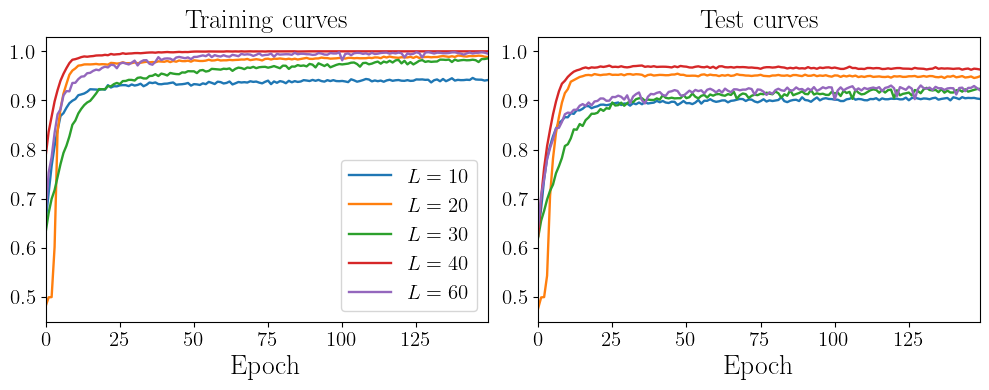

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplots
axes[0].set_title("Training curves")
axes[1].set_title("Test curves")
axes[0].set_xlabel('Epoch')
axes[1].set_xlabel('Epoch')
axes[0].set_xlim(0, epochs - 1)
axes[1].set_xlim(0, epochs - 1)
axes[0].set_ylim(0.45, 1.03)
axes[1].set_ylim(0.45, 1.03)


for i, train_curve in enumerate(model_accuracies_train):
    axes[0].plot(train_curve, label=f'$L = {lengths_list[i]}$', linewidth=1.7, markersize=4)
    axes[1].plot(model_accuracies_test[i], linewidth=1.7, markersize=4)

plt.tight_layout()
axes[0].legend()
plt.show()


Plot the average output for each temperature for the training set and the test set.

In [9]:
# Evalute output for entire training and test sets.
outputs_train = torch.stack([
    models[i](lattices_train[i]) for i in range(len(lengths_list))
])
outputs_test = torch.stack([
    models[i](lattices_test[i]) for i in range(len(lengths_list))
])
predictions_train = torch.argmax(outputs_train, dim=2)
predictions_test = torch.argmax(outputs_test, dim=2)

# Remove duplicates from temperature data and count the number of datapoints per temperature
unique_temp_test, counts = torch.unique(temperatures_test[0], return_counts=True)
num_copies_T_test = counts[0].item()
unique_temp_train, counts = torch.unique(temperatures_train[0], return_counts=True)
num_copies_T_train = counts[0].item()

# Sort the predictions by temperature
sort_by_temp_test = torch.argsort(temperatures_test, dim=1)
sort_by_temp_train = torch.argsort(temperatures_train, dim=1)

sorted_pred_test = torch.gather(predictions_test, dim=1, index=sort_by_temp_test)
sorted_pred_train = torch.gather(predictions_train, dim=1, index=sort_by_temp_train)

avg_pred_test = sorted_pred_test.view(sorted_pred_test.shape[0], -1, num_copies_T_test).sum(dim=2) / num_copies_T_test
avg_pred_train = sorted_pred_train.view(sorted_pred_train.shape[0], -1, num_copies_T_train).sum(dim=2) / num_copies_T_train

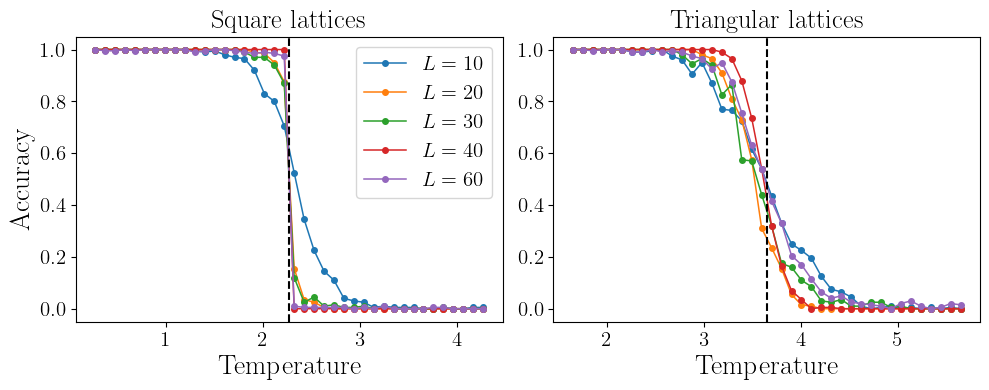

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplots
axes[0].set_title("Square lattices")
axes[1].set_title("Triangular lattices")
axes[0].set_xlabel('Temperature')
axes[1].set_xlabel('Temperature')
axes[0].set_ylabel('Accuracy')

for i, train_curve in enumerate(avg_pred_test):
    axes[0].plot(unique_temp_train, avg_pred_train[i], label=f'$L = {lengths_list[i]}$', linewidth=1.1, marker='o', markersize=4)
    axes[1].plot(unique_temp_test, avg_pred_test[i], linewidth=1.1, marker='o', markersize=4)

axes[0].axvline(x=Tc_train, color='black', linestyle='dashed')
axes[1].axvline(x=Tc_test, color='black', linestyle='dashed')

plt.tight_layout()
axes[0].legend()
plt.show()

Plot the accuracy with respect to temperature for each model.

In [11]:
# Sort the labels and predictions by temperature
sorted_labels_test = torch.gather(labels_test, dim=1, index=sort_by_temp_test)

# Take average for each temperature
accuracies_test = (sorted_pred_test == sorted_labels_test)
accuracies_test = accuracies_test.view(accuracies_test.shape[0], -1, num_copies_T_test).sum(dim=2) / num_copies_T_test

# Sort the labels and predictions by temperature
sorted_labels_train = torch.gather(labels_train, dim=1, index=sort_by_temp_train)

# Take average for each temperature
accuracies_train = (sorted_pred_train == sorted_labels_train)
accuracies_train = accuracies_train.view(accuracies_train.shape[0], -1, num_copies_T_train).sum(dim=2) / num_copies_T_train

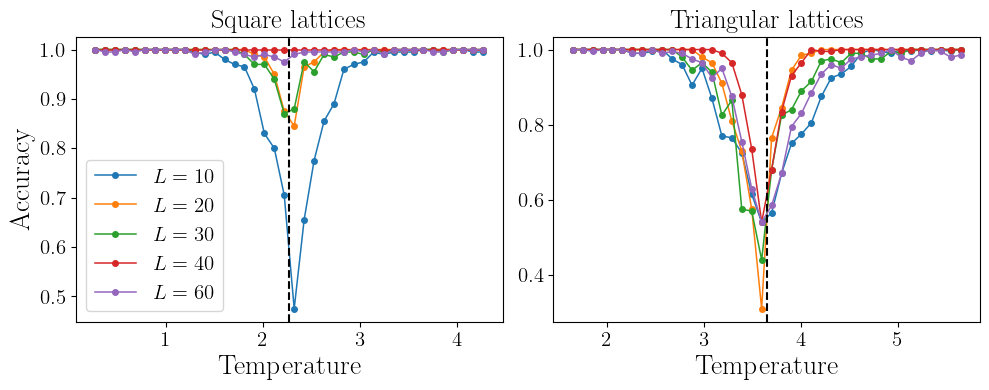

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplots
axes[0].set_title("Square lattices")
axes[1].set_title("Triangular lattices")
axes[0].set_xlabel('Temperature')
axes[1].set_xlabel('Temperature')
axes[0].set_ylabel('Accuracy')

for i, train_curve in enumerate(avg_pred_test):
    axes[0].plot(unique_temp_train, accuracies_train[i], label=f'$L = {lengths_list[i]}$', linewidth=1.1, marker='o', markersize=4)
    axes[1].plot(unique_temp_test, accuracies_test[i], linewidth=1.1, marker='o', markersize=4)

axes[0].axvline(x=Tc_train, color='black', linestyle='dashed')
axes[1].axvline(x=Tc_test, color='black', linestyle='dashed')

plt.tight_layout()
axes[0].legend()
plt.show()